# Airbnb in Madrid

This project is developed under the CRISP-DM process. This include:
    
1.Business Understanding

2. Prepare Data

3. Data Understanding

4. Data Modeling

5. Evaluate the Results

6. Deploy   

## 1 Business Understanding

Airbnb is a relative young company that has experimented an incredible growth in the past 20 years. Its main business is to connect people who offers rooms with people that needs them. Prices vary depending on several factors, as location, cleanliness... 
In this project, we will try to find some patterns and extract some insight. 

## 2 Prepare Data

### 2.1 Load the data

In [64]:
#import libaries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from IPython import display
import collections
from time import time
from itertools import chain
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
import seaborn as sns
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

import plotly.graph_objects as go

#from helper import prepare_listings

In [65]:
calendar=pd.read_csv("calendar.csv")
print(calendar.head(2))
calendar.shape

   listing_id        date available   price adjusted_price  minimum_nights  \
0      100411  2020-04-17         f  $60.00         $60.00             2.0   
1      102040  2020-04-18         f  $22.00         $22.00             3.0   

   maximum_nights  
0            30.0  
1            90.0  


(7954004, 7)

In [66]:
reviews_df=pd.read_csv("reviews.csv")
print(reviews_df.head(2))
reviews_df.shape

   listing_id     id        date  reviewer_id reviewer_name  \
0        6369  29428  2010-03-14        84790         Nancy   
1        6369  31018  2010-03-23        84338         David   

                                            comments  
0  Simon and Arturo have the ultimate location in...  
1  Myself and Kristy originally planned on stayin...  


(824418, 6)

In [67]:
listings=pd.read_csv("listings.csv")
listings.head(2)
listings.shape

C:\Users\PC\Documents\Anaconda3\envs\tf-gpu-15\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(21791, 106)

### 2.2 NA treatment

In [68]:
listings.isna().sum().sort_values()

id                            0
minimum_maximum_nights        0
maximum_minimum_nights        0
minimum_minimum_nights        0
maximum_nights                0
                          ...  
square_feet               21507
xl_picture_url            21791
thumbnail_url             21791
jurisdiction_names        21791
medium_url                21791
Length: 106, dtype: int64

#### check NA values


In [69]:
len(listings)

21791

In [70]:
(listings.isnull().sum()/len(listings)).sort_values(ascending=False)

#drop all the columns with all rows as na. 
#In this case, we will delete all the columns with all rows as NA. Since all the columns has NA, there is no info there.
listings=listings.dropna(how="all",axis="columns")

#tdrop columns with more than 60% of na
df_listing_cl = listings.drop(columns = listings.columns[listings.isna().mean() > 0.70])
#drop all the colums with the word "url" in it.

url_cols=[col for col in df_listing_cl.columns.values if 'url' in col]
df_listing_cl=df_listing_cl.drop(columns=url_cols)

In [71]:
df_listing_cl.isna().sum().sort_values()

id                                  0
neighbourhood_group_cleansed        0
availability_30                     0
has_availability                    0
calendar_updated                    0
                                ...  
interaction                      9025
house_rules                      9171
host_about                      10414
access                          11361
notes                           12952
Length: 93, dtype: int64

### 2.3 Categorical treatment

 transform columns with 1 or 0 


In [72]:
binary_cols=['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact'
             ,'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
             'has_availability','requires_license','is_business_travel_ready']
df_listing_cl[binary_cols]=np.where(df_listing_cl[binary_cols]=='t', 1, 0)
df_listing_cl[binary_cols]=df_listing_cl[binary_cols].astype(np.uint8)

some columns are description, etc. Since NLP is beyond of the scope of this project, it will be filled with 1 if there is info in the 
cell, and 0 y it is null.

In [73]:

cat=['experiences_offered', 'neighborhood_overview', 'transit','description','space','summary']
df_listing_cl[cat]=np.where(df_listing_cl[cat] != "NaN", 1, 0)
df_listing_cl[cat]=df_listing_cl[cat].astype(np.uint8)

This will help us to filter variables

In [74]:
df_listing_cl[df_listing_cl.select_dtypes(include=["uint8"]).columns]=df_listing_cl[df_listing_cl.select_dtypes(include=["uint8"]).columns].astype("category")


convert price and extra numeric data that is in a wrong format


In [75]:
for column in ["price","extra_people","cleaning_fee","security_deposit"]:
    df_listing_cl[column]=df_listing_cl[column].replace('[\$,]', '', regex=True).astype(float)

let's delete unused columns


In [76]:
unused_columns=["host_since","host_location","host_response_time","host_response_rate","host_acceptance_rate",
              "host_verifications","street","calendar_updated","calendar_last_scraped","first_review","last_review",
               "country","country_code","state","market","smart_location","cancellation_policy","reviews_per_month",
               "name","host_name","scrape_id","last_scraped","neighborhood_overview","neighborhood_overview","requires_license",
                "host_neighbourhood","description"]
df_listing_cl=df_listing_cl.drop(columns=unused_columns)
df_listing_cl

,id,summary,space,experiences_offered,notes,transit,access,interaction,house_rules,host_id,...,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,6369,1,1,1,If you are a group/family 3 or 4 people we off...,1,"Full use of living room, kitchen (with dishwas...","English, spanish, german, russian, some french...",NaN,13660,...,10.0,10.0,0,0,0,0,1,0,1,0
1,21853,1,1,1,We are a 15 min bus ride away from the Casa de...,1,There is fibre optic internet connection for y...,If I am at home and see each other around here...,Gracias por no fumar en la casa. Es muy import...,83531,...,8.0,9.0,0,0,0,0,2,0,2,0
2,23001,1,1,1,NaN,1,"Piscina de verano, zonas comunes en el interio...",NaN,"Preparacion apartamento , entrega llaves 20 € ...",82175,...,NaN,NaN,0,0,0,0,6,5,1,0
3,24836,1,1,1,Al estar en el distrito Centro (Barrio de Just...,1,La disponibilidad de acceso al apartamento es ...,El precio marcado es por el alojamiento comple...,"El apartamento admite bebés, aunque no tiene c...",101653,...,10.0,10.0,0,0,0,0,1,1,0,0
4,26825,1,1,1,Airport to Apart. You can take a Taxi (30€) or...,1,– Smoking is prohibited in rooms and public ar...,NaN,For problems that I have lived with other gues...,114340,...,9.0,9.0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,43204745,1,1,1,NaN,1,NaN,NaN,NaN,344003812,...,NaN,NaN,1,0,0,0,1,1,0,0
21787,43206188,1,1,1,NaN,1,NaN,Suelo estas fuera de casa por trabajo pero sie...,NaN,109300368,...,NaN,NaN,1,0,0,0,1,0,1,0
21788,43207981,1,1,1,NaN,1,NaN,Estaré disponible durante horario diurno,"A partir de las 00, restringir música y conver...",168001538,...,NaN,NaN,1,0,0,0,2,0,2,0
21789,43208445,1,1,1,NaN,1,NaN,Yo duermo en la habitación principal Tengo un ...,NaN,168001538,...,NaN,NaN,1,0,0,0,2,0,2,0


## 3 Data Understanding

In [77]:
df_listings_affect=df_listing_cl.copy()

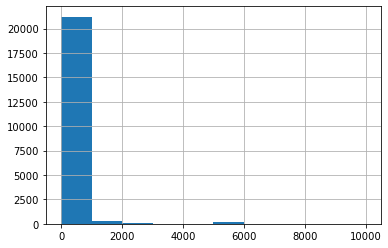

In [78]:
df_listings_affect.price.hist()

300 € will be the maximum price per night.  

In [79]:
df_listings_affect = df_listings_affect[df_listings_affect.price<300]

### 3.1 Check numeric values

In [80]:
df_listings_affect_numeric=df_listings_affect.select_dtypes(exclude=["category","object"]).sort_values("price")

In [81]:
df_listings_affect_numeric.isna().sum()

id                                                 0
host_id                                            0
host_listings_count                                4
host_total_listings_count                          4
latitude                                           0
longitude                                          0
accommodates                                       0
bathrooms                                         11
bedrooms                                          30
beds                                             288
price                                              0
security_deposit                                6335
cleaning_fee                                    4753
guests_included                                    0
extra_people                                       0
minimum_nights                                     0
maximum_nights                                     0
minimum_minimum_nights                             0
maximum_minimum_nights                        

filling all the columns with median of respective column. Here we have imputed the median due to it is better to input that data than to delete all those columns. 


In [82]:
for col in df_listings_affect_numeric.columns[df_listings_affect_numeric.isnull().any()]:
    df_listings_affect_numeric[col] = df_listings_affect_numeric[col].fillna(df_listings_affect_numeric[col].median())

In [83]:
df_listings_affect_numeric.isna().sum()

id                                              0
host_id                                         0
host_listings_count                             0
host_total_listings_count                       0
latitude                                        0
longitude                                       0
accommodates                                    0
bathrooms                                       0
bedrooms                                        0
beds                                            0
price                                           0
security_deposit                                0
cleaning_fee                                    0
guests_included                                 0
extra_people                                    0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0


In [84]:
df_listings_affect_numeric.beds[df_listings_affect_numeric.beds==0]=1

C:\Users\PC\Documents\Anaconda3\envs\tf-gpu-15\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
df_listings_affect_numeric["price_per_room"]=df_listings_affect_numeric["price"]/df_listings_affect_numeric["bedrooms"]

In [86]:
df_listings_affect_numeric["price_per_bed"]=df_listings_affect_numeric["price"]/df_listings_affect_numeric["beds"]

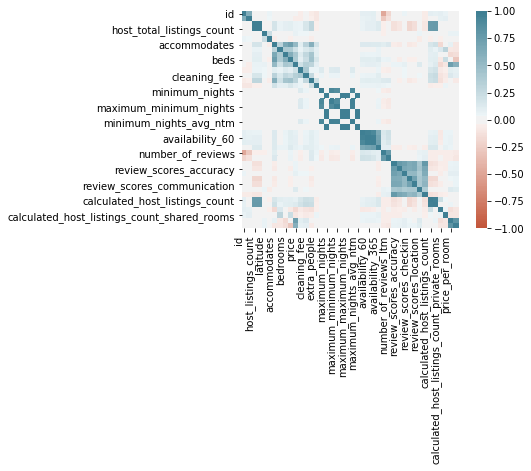

In [87]:
corrMatrix = df_listings_affect_numeric.corr()

ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

figure = ax.get_figure().savefig('df_listings_affect_numeric.png',bbox_inches="tight")   

In [88]:
corrMatrix["review_scores_rating"].sort_values()

calculated_host_listings_count                 -0.125427
host_listings_count                            -0.120880
host_total_listings_count                      -0.120880
calculated_host_listings_count_entire_homes    -0.110121
accommodates                                   -0.059032
calculated_host_listings_count_private_rooms   -0.058709
availability_365                               -0.054345
calculated_host_listings_count_shared_rooms    -0.049952
beds                                           -0.037857
host_id                                        -0.031151
guests_included                                -0.025490
availability_30                                -0.024044
availability_60                                -0.021827
availability_90                                -0.021304
id                                             -0.002939
maximum_nights                                 -0.002300
maximum_maximum_nights                         -0.002287
maximum_nights_avg_ntm         

### 3.2 Check categorical values

In [89]:
df_listings_affect_category=df_listings_affect.select_dtypes(include=["object","category"])
df_listings_affect_category=df_listings_affect_category.drop(columns=["city","zipcode","neighbourhood","neighbourhood_cleansed"])

In [90]:
df_listings_affect_category.isna().sum()

summary                                 0
space                                   0
experiences_offered                     0
notes                               11559
transit                                 0
access                              10005
interaction                          7991
house_rules                          8182
host_about                           9407
host_is_superhost                       0
host_has_profile_pic                    0
host_identity_verified                  0
neighbourhood_group_cleansed            0
is_location_exact                       0
property_type                           0
room_type                               0
bed_type                                1
amenities                               0
has_availability                        0
instant_bookable                        0
is_business_travel_ready                0
require_guest_profile_picture           0
require_guest_phone_verification        0
dtype: int64

lets one hot encoding the other variables
encoding property_type

In [91]:
for col in ["bed_type","room_type","property_type"]:
    # generate binary values using get_dummies
    df_listings_affect_category = pd.get_dummies(df_listings_affect_category, columns=[col], prefix=[col+"_is"],dtype="uint8")

In [92]:
df_listings_affect_category.head()

,summary,space,experiences_offered,notes,transit,access,interaction,house_rules,host_about,host_is_superhost,...,property_type_is_Hut,property_type_is_Loft,property_type_is_Other,property_type_is_Pension (South Korea),property_type_is_Serviced apartment,property_type_is_Tent,property_type_is_Tiny house,property_type_is_Townhouse,property_type_is_Villa,property_type_is_Yurt
0,1,1,1,If you are a group/family 3 or 4 people we off...,1,"Full use of living room, kitchen (with dishwas...","English, spanish, german, russian, some french...",NaN,"Gay couple, heterofriendly, enjoy having guest...",1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,We are a 15 min bus ride away from the Casa de...,1,There is fibre optic internet connection for y...,If I am at home and see each other around here...,Gracias por no fumar en la casa. Es muy import...,EN-ES-FR\r\nEN\r\nHi everybody: I'm Abdel. I'm...,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,NaN,1,"Piscina de verano, zonas comunes en el interio...",NaN,"Preparacion apartamento , entrega llaves 20 € ...","Hi,\r\n\r\nWelcome to my apartments in the dow...",0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,Al estar en el distrito Centro (Barrio de Just...,1,La disponibilidad de acceso al apartamento es ...,El precio marcado es por el alojamiento comple...,"El apartamento admite bebés, aunque no tiene c...",Mi mayor pasión es viajar y conocer culturas d...,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,Airport to Apart. You can take a Taxi (30€) or...,1,– Smoking is prohibited in rooms and public ar...,NaN,For problems that I have lived with other gues...,"I like Fine art, Photography, Cinema, travel a...",0,...,0,0,0,0,0,0,0,0,0,0


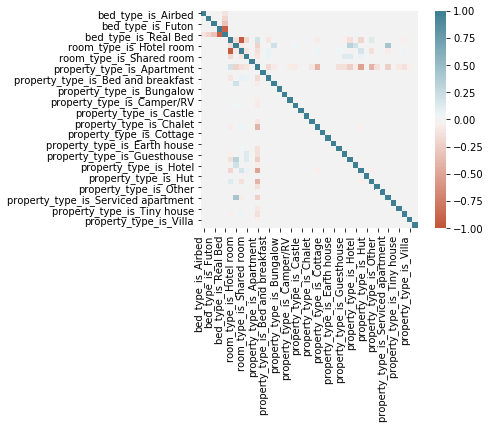

In [93]:
corrMatrix = df_listings_affect_category.corr()

ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
figure = ax.get_figure().savefig('df_listings_affect_category.png',bbox_inches="tight")   

### 3.3 Amenities

In [94]:
df_listings_affect_amenities=df_listings_affect["amenities"].str.replace('"',"").str.replace("}","").str.replace("{","").str.split(',',expand=True)

# Add all amenities in dataframe to list
amenities_unique=[df_listings_affect_amenities[x].unique().tolist() for x in df_listings_affect_amenities.columns.values]

# Get unique values of amenities
amenities_unique=set(list(chain.from_iterable(amenities_unique)))
print(amenities_unique)

# Remove '' and None values
amenities_unique.remove('')
amenities_unique.remove(None)

# Create binary amenity columns
for index in range(30):
    for a in amenities_unique:
        df_listings_affect_amenities[a] = 0

for index in range(30):
    for a in amenities_unique:
        df_listings_affect_amenities[a] += np.where(df_listings_affect_amenities[index] == a, 1, 0)

# Drop redundant column
df_listings_affect_amenities.drop(columns=[x for x in range(85)],inplace=True)
df_listings_affect_amenities=df_listings_affect_amenities.astype(np.uint8)

{'', 'Outlet covers', 'TV', 'Walk-in shower', 'Baby monitor', 'Fixed grab bars for shower', 'Doorman', 'Iron', 'Beachfront', 'DVD player', 'Breakfast', 'Amazon Echo', 'Cooking basics', 'Pack ’n Play/travel crib', 'Heated floors', 'Wide entrance for guests', 'Front desk', 'Wifi', 'Fireplace guards', 'Electric profiling bed', 'Wine cooler', 'Microwave', 'Body soap', 'Free street parking', 'Washer', ' toilet', 'Wide clearance to shower', 'Warming drawer', 'Coffee maker', 'Kitchenette', 'Mini fridge', 'Air conditioning', 'Bathtub', 'Touchless faucets', 'Bed linens', 'Pets live on this property', 'Espresso machine', 'Projector and screen', 'Convection oven', 'Essentials', 'Shower gel', 'Self check-in', 'Keypad', 'Patio or balcony', 'Buzzer/wireless intercom', '24-hour check-in', 'Central air conditioning', 'Hammock', 'Cleaning before checkout', 'Indoor fireplace', 'Washer/Dryer', 'Children’s dinnerware', 'Host greets you', 'Paid parking off premises', 'Accessible-height bed', 'Private bathr

In [95]:
# Append amenities columns to original dataframe
df_listings_affect_amenities

,Outlet covers,TV,Walk-in shower,Baby monitor,Fixed grab bars for shower,Doorman,Iron,Beachfront,DVD player,Breakfast,...,Bidet,Wheelchair accessible,translation missing: en.hosting_amenity_50,Paid parking on premises,Oven,Handheld shower head,Disabled parking spot,Extra pillows and blankets,Fixed grab bars for toilet,Shampoo
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,1,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1
2,0,1,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
21787,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21788,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21789,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


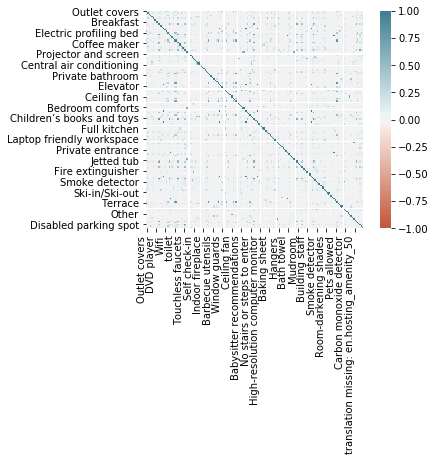

In [96]:
corrMatrix = df_listings_affect_amenities.corr()

ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
figure = ax.get_figure().savefig('df_listings_affect_amenities.png',bbox_inches="tight")   

# 1. How to get good reviews?

Add together all the dataframes

In [97]:
df_listings_affect_total=df_listings_affect_numeric.join(df_listings_affect_category,how='left')
df_listings_affect_total=df_listings_affect_total.join(df_listings_affect_amenities,how='left')
df_listings_affect_total.head()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,Bidet,Wheelchair accessible,translation missing: en.hosting_amenity_50,Paid parking on premises,Oven,Handheld shower head,Disabled parking spot,Extra pillows and blankets,Fixed grab bars for toilet,Shampoo
20715,42431465,312021837,6.0,6.0,40.40884,-3.71704,12,1.0,1.0,2.0,...,0,0,0,0,0,0,0,1,0,1
17029,37895369,120675467,1.0,1.0,40.46456,-3.74822,1,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6979,20049665,68664241,3.0,3.0,40.39622,-3.69926,1,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
5747,18351752,69998776,1.0,1.0,40.42576,-3.63870,1,1.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1
11357,29117007,108022834,1.0,1.0,40.42369,-3.64993,2,1.0,2.0,3.0,...,0,0,0,0,0,0,0,0,0,1


After a first view, select the most relevants columns

In [98]:
columns=["review_scores_rating","review_scores_value","review_scores_accuracy","review_scores_cleanliness","review_scores_communication",    
"review_scores_checkin","review_scores_location","Dishwasher", "Hangers","First aid kit","Laptop friendly workspace",
"Shampoo", "Carbon monoxide detector", "Breakfast","Coffee maker", "price_per_bed", "Smoke detector",                 
"Iron","Extra pillows and blankets","price","Oven","price_per_room","Hair dryer","Patio or balcony","room_type_is_Private room"]

Let's plot the correlation matrix heatmap

In [99]:
corrMatrix = df_listings_affect_total[columns].corr()
fig, ax = plt.subplots(figsize=(20,20),dpi=600) 
ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
figure = ax.get_figure().savefig('df_listings_affect_TOTAL.png',bbox_inches="tight")  

In [100]:
corrMatrix["review_scores_rating"].sort_values(ascending=False).head(25)

review_scores_rating           1.000000
review_scores_value            0.781846
review_scores_accuracy         0.772914
review_scores_cleanliness      0.720951
review_scores_communication    0.678739
review_scores_checkin          0.642806
review_scores_location         0.428810
Dishwasher                     0.110400
Hangers                        0.093614
First aid kit                  0.091190
Laptop friendly workspace      0.088459
Shampoo                        0.080932
Carbon monoxide detector       0.079906
Breakfast                      0.075110
Coffee maker                   0.069908
price_per_bed                  0.068788
Smoke detector                 0.064128
Iron                           0.063955
Extra pillows and blankets     0.063258
price                          0.061390
Oven                           0.061156
price_per_room                 0.058820
Hair dryer                     0.055706
Patio or balcony               0.050561
room_type_is_Private room      0.050186


# 2. How is the distribution of the Airbnb?

Airbnb was thought for people to rent free rooms to get a way to earn some extra cash. What does data say about this first idea? Let’s plot it.

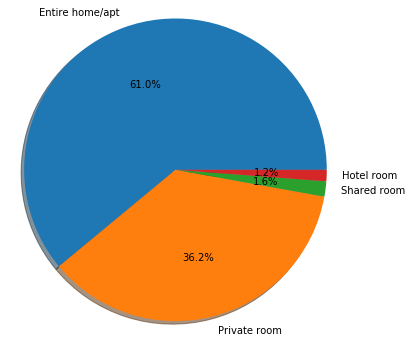

In [101]:
df_listing_cl=df_listing_cl

data = (df_listing_cl['room_type'].value_counts())
labels =data.keys().tolist()
sizes = [ str(item) for item in (df_listing_cl['room_type'].value_counts())]
explode = (0, 0, 0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The 62.2% of the Airbnb apartments in Madrid are entire apartments, homes, or hotel rooms, what means not sharing one of your free rooms, but to buy an apartment and use it just to rent it in Airbnb. Only the 37.8% are private rooms or shared rooms.

Plot the distribution of the apartments per host

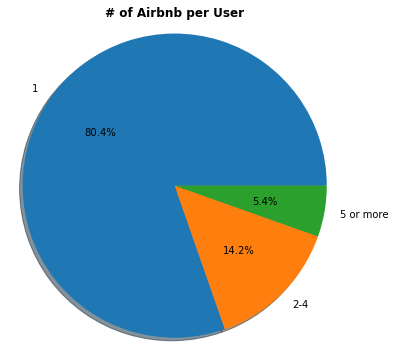

In [102]:
listings_entire_home_or_hotel=df_listing_cl[df_listing_cl["room_type"].isin(["Entire home/apt","Hotel room"])]

listings_entire_home_or_hotel = (
    listings_entire_home_or_hotel
    .groupby('host_id')
    .size())
bins=pd.cut(listings_entire_home_or_hotel, bins=[1,2,5,500],include_lowest=True, right=False)
data = bins.value_counts().tolist()
percent=[x / (sum(data)/100) for x in data]
percent
labels = "1","2-4","5 or more"
sizes = percent
explode = (0, 0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('# of Airbnb per User', weight='bold')

plt.show()

From all the entire homes/apartment to rent, 19.6% have 2 or more Airbnb to rent, and 5.4% have 5 of more. The list bellow shows the number if apartments per host id:
Image for post
The firsts 5 hosts have more than 100 apartments to rent. Depending on the price to paid for the apartment, this is a very lucrative business.

## Additional info

In [103]:
BBox = ((df_listing_cl.longitude.min(),   df_listing_cl.longitude.max(),      
         df_listing_cl.latitude.min(), df_listing_cl.latitude.max()))
print(BBox)

(-3.8639099999999997, -3.52766, 40.33247, 40.562740000000005)


In [104]:
ruh_m = plt.imread('Madrid.png')

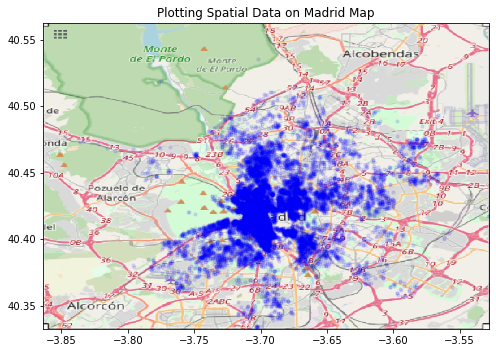

In [105]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_listing_cl.longitude, df_listing_cl.latitude, zorder=1, alpha= 0.1, c='b', s=10)
ax.set_title('Plotting Spatial Data on Madrid Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

,id,summary,space,experiences_offered,notes,transit,access,interaction,house_rules,host_id,...,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,6369,1,1,1,If you are a group/family 3 or 4 people we off...,1,"Full use of living room, kitchen (with dishwas...","English, spanish, german, russian, some french...",NaN,13660,...,10.0,10.0,0,0,0,0,1,0,1,0
1,21853,1,1,1,We are a 15 min bus ride away from the Casa de...,1,There is fibre optic internet connection for y...,If I am at home and see each other around here...,Gracias por no fumar en la casa. Es muy import...,83531,...,8.0,9.0,0,0,0,0,2,0,2,0
2,23001,1,1,1,NaN,1,"Piscina de verano, zonas comunes en el interio...",NaN,"Preparacion apartamento , entrega llaves 20 € ...",82175,...,NaN,NaN,0,0,0,0,6,5,1,0
3,24836,1,1,1,Al estar en el distrito Centro (Barrio de Just...,1,La disponibilidad de acceso al apartamento es ...,El precio marcado es por el alojamiento comple...,"El apartamento admite bebés, aunque no tiene c...",101653,...,10.0,10.0,0,0,0,0,1,1,0,0
4,26825,1,1,1,Airport to Apart. You can take a Taxi (30€) or...,1,– Smoking is prohibited in rooms and public ar...,NaN,For problems that I have lived with other gues...,114340,...,9.0,9.0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,43204745,1,1,1,NaN,1,NaN,NaN,NaN,344003812,...,NaN,NaN,1,0,0,0,1,1,0,0
21787,43206188,1,1,1,NaN,1,NaN,Suelo estas fuera de casa por trabajo pero sie...,NaN,109300368,...,NaN,NaN,1,0,0,0,1,0,1,0
21788,43207981,1,1,1,NaN,1,NaN,Estaré disponible durante horario diurno,"A partir de las 00, restringir música y conver...",168001538,...,NaN,NaN,1,0,0,0,2,0,2,0
21789,43208445,1,1,1,NaN,1,NaN,Yo duermo en la habitación principal Tengo un ...,NaN,168001538,...,NaN,NaN,1,0,0,0,2,0,2,0


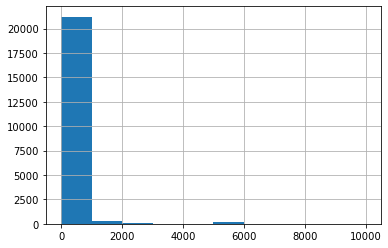

In [106]:
df_listing_cl["price"].hist()
#quitamos los outliers
df_listing_cl=df_listing_cl[df_listing_cl["price"]<300]
df_listing_cl

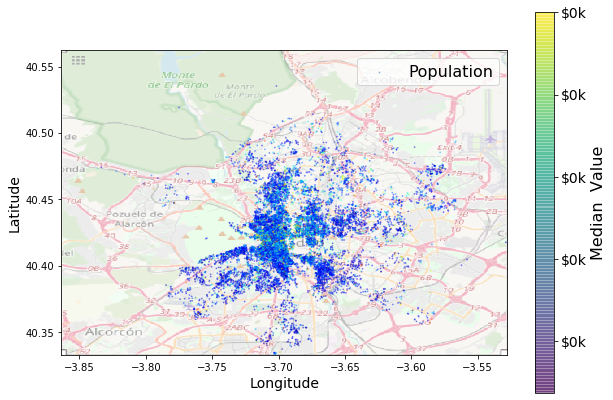

In [107]:
import numpy as np
import matplotlib.image as mpimg

def plot_Airbnb_map(df):
    """
    function to plot the Airbnb data over the map
    Args: df
    return: None
    """
    # define the points to be ploted in the map
    Madrid_img=mpimg.imread('Madrid.png')
    ax = df.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                           s=0.7, label="Population",
                           c="price", cmap=plt.get_cmap("jet"),
                           colorbar=False, alpha=0.4,
                          )
    #define the img and size
    plt.imshow(Madrid_img, extent=BBox, alpha=0.5)
    plt.ylabel("Latitude", fontsize=14)
    plt.xlabel("Longitude", fontsize=14)

    prices = df["price"]
    tick_values = np.linspace(prices.min(), prices.max(), 11)
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
    cbar.set_label('Median  Value', fontsize=16)

    plt.legend(fontsize=16)
    plt.show()

plot_Airbnb_map(df_listing_cl)

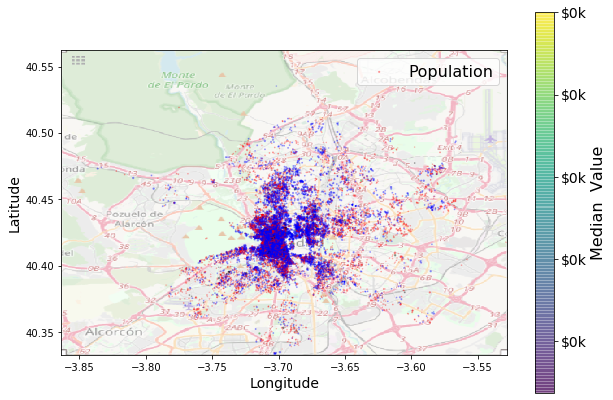

In [108]:
import numpy as np
import matplotlib.image as mpimg
california_img=mpimg.imread('Madrid.png')

#define dict with colors for differents rooms
colors = {"Private room":'red', 'Entire home/apt':'blue', 'Hotel room':'green', 'Shared room':'black'}

#define the points
ax = df_listing_cl.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=df_listing_cl.price/100, label="Population",
                       c=df_listing_cl["room_type"].apply(lambda x: colors[x]), cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.3,
                  
                    )
#define img size of the map
plt.imshow(california_img, extent=BBox, alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df_listing_cl["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
#define lateral bar
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median  Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [109]:
df_listing_cl.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

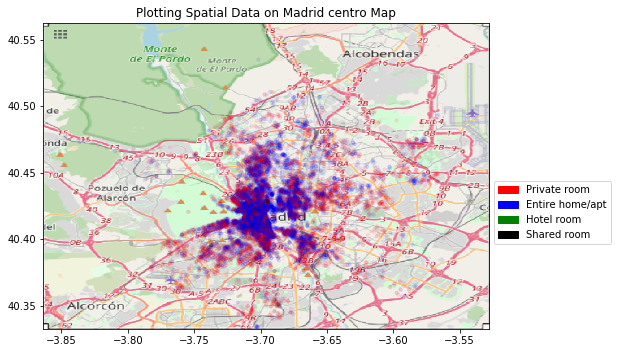

In [110]:
fig, ax = plt.subplots(figsize = (8,7))

#define dict 
colors = {"Private room":'red', 'Entire home/apt':'blue', 'Hotel room':'green', 'Shared room':'black'}

#define plot
ax.scatter(df_listing_cl.longitude, df_listing_cl.latitude, zorder=1, alpha= 0.07, c=df_listing_cl["room_type"].apply(lambda x: colors[x]), s=10)

#define legend
red_patch = mpatches.Patch(color='red', label='Private room')
blue_patch = mpatches.Patch(color='blue', label='Entire home/apt')
green_patch = mpatches.Patch(color='green', label='Hotel room')
black_patch = mpatches.Patch(color='black', label='Shared room')


plt.legend( handles=[red_patch,blue_patch,green_patch,black_patch],bbox_to_anchor=(1, 0.5))
#plot
ax.set_title('Plotting Spatial Data on Madrid centro Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(california_img, zorder=0, extent = BBox, aspect= 'equal')

(-3.72015, -3.69095, 40.40554, 40.42992)


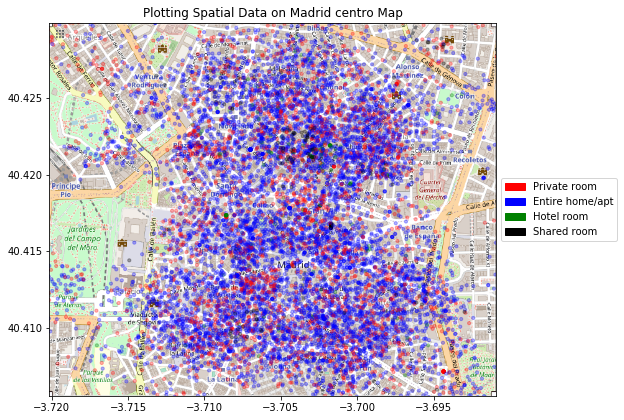

In [111]:
centro=df_listing_cl[df_listing_cl["neighbourhood_group_cleansed"]=="Centro"]

#define the size of the image
BBox_centro = ((centro.longitude.min(),   centro.longitude.max(),      
         centro.latitude.min(), centro.latitude.max()))
print(BBox_centro)
ruh_m_centro= plt.imread('Madrid_centro.png')
fig, ax = plt.subplots(figsize = (8,7))

#dict of rooms and colours
colors = {"Private room":'red', 'Entire home/apt':'blue', 'Hotel room':'green', 'Shared room':'black'}

#define plot
ax.scatter(df_listing_cl.longitude, df_listing_cl.latitude, zorder=1, alpha= 0.3, c=df_listing_cl["room_type"].apply(lambda x: colors[x]), s=10)

#define legend
red_patch = mpatches.Patch(color='red', label='Private room')
blue_patch = mpatches.Patch(color='blue', label='Entire home/apt')
green_patch = mpatches.Patch(color='green', label='Hotel room')
black_patch = mpatches.Patch(color='black', label='Shared room')


plt.legend( handles=[red_patch,blue_patch,green_patch,black_patch],bbox_to_anchor=(1, 0.5))

#plot
ax.set_title('Plotting Spatial Data on Madrid centro Map')
ax.set_xlim(BBox_centro[0],BBox_centro[1])
ax.set_ylim(BBox_centro[2],BBox_centro[3])
ax.imshow(ruh_m_centro, zorder=0, extent = BBox_centro, aspect= 'equal')

In [112]:
df_listing_cl.neighbourhood_group_cleansed.unique()

array(['Chamartín', 'Latina', 'Arganzuela', 'Centro',
       'Fuencarral - El Pardo', 'Salamanca', 'Tetuán',
       'Puente de Vallecas', 'Ciudad Lineal', 'Chamberí', 'Villaverde',
       'Hortaleza', 'Moncloa - Aravaca', 'Carabanchel', 'Retiro',
       'San Blas - Canillejas', 'Villa de Vallecas', 'Barajas', 'Usera',
       'Moratalaz', 'Vicálvaro'], dtype=object)

# 3. reviews: Is there a trend in the reviews number?

check the data

In [113]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6369,29428,2010-03-14,84790,Nancy,Simon and Arturo have the ultimate location in...
1,6369,31018,2010-03-23,84338,David,Myself and Kristy originally planned on stayin...
2,6369,34694,2010-04-10,98655,Marion,We had a great time at Arturo and Simon's ! A ...
3,6369,37146,2010-04-21,109871,Kurt,I very much enjoyed the stay. \r\nIt's a wond...
4,6369,38168,2010-04-26,98901,Dennis,Arturo and Simon are polite and friendly hosts...


Transform to datetype

In [114]:
reviews_df.date=pd.to_datetime(reviews_df.date)

In [115]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])  

In [116]:
reviews_df_dates=reviews_df.set_index('date').id

### plot the total trend

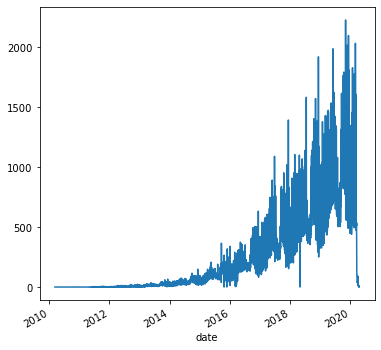

In [117]:
fig, axs = plt.subplots(1,1,figsize=(6,6))


reviews_df.groupby("date").id.count().plot(ax=axs)

fig.savefig("reviewtotaltrend.png")

Now, let’s see what the number of reviews can tell us from Airbnb.
From the bellow plot, the first information we can extract is the awesome growth of this company. The number of reviews has increse, from 2012, a 15859%.

let's plot each period

In [118]:
mask_dates_12 = (reviews_df['date'] > '2012-1-1') & (reviews_df['date'] <= '2013-1-1')
reviews_df_dates_12=reviews_df.loc[mask_dates_12]
reviews_df_dates_12.id.count()

1874

In [119]:
mask_dates_19 = (reviews_df['date'] > '2019-1-1') & (reviews_df['date'] <= '2020-1-1')
reviews_df_dates_19=reviews_df.loc[mask_dates_19]
reviews_df_dates_19.id.count()

299076

In [120]:
((reviews_df_dates_19.id.count()- reviews_df_dates_12.id.count())/reviews_df_dates_12.id.count())*100


15859.231590181429

In [121]:
mask_dates_19 = pd.date_range('2019/01/01','2020/1/1')
mask_dates_19 = (reviews_df['date'] > '2019-1-1') & (reviews_df['date'] <= '2020-1-1')
reviews_df_dates_19=reviews_df.loc[mask_dates_19]


In [122]:
mask_dates_18 = (reviews_df['date'] > '2018-1-1') & (reviews_df['date'] <= '2019-1-1')
reviews_df_dates_18=reviews_df.loc[mask_dates_18]

In [123]:
mask_dates_19 = pd.date_range('2019/01/01','2020/1/1')
mask_dates_19 = (reviews_df['date'] > '2019-1-1') & (reviews_df['date'] <= '2020-1-1')
reviews_df_dates_19=reviews_df.loc[mask_dates_19]

In [124]:
mask_dates_18 = (reviews_df['date'] > '2018-1-1') & (reviews_df['date'] <= '2019-1-1')
reviews_df_dates_18=reviews_df.loc[mask_dates_18]

In [125]:
mask_dates_17 = (reviews_df['date'] > '2017-1-1') & (reviews_df['date'] <= '2018-1-1')
reviews_df_dates_17=reviews_df.loc[mask_dates_17]

In [126]:
mask_dates_16 = (reviews_df['date'] > '2016-1-1') & (reviews_df['date'] <= '2017-1-1')
reviews_df_dates_16=reviews_df.loc[mask_dates_16]

In [127]:
reviews_df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6369,29428,2010-03-14,84790,Nancy,Simon and Arturo have the ultimate location in...
1,6369,31018,2010-03-23,84338,David,Myself and Kristy originally planned on stayin...
2,6369,34694,2010-04-10,98655,Marion,We had a great time at Arturo and Simon's ! A ...
3,6369,37146,2010-04-21,109871,Kurt,I very much enjoyed the stay. \r\nIt's a wond...
4,6369,38168,2010-04-26,98901,Dennis,Arturo and Simon are polite and friendly hosts...
...,...,...,...,...,...,...
824413,43052741,621323875,2020-03-30,164630569,Angel,"Todo muy bien, muy limpio y la atención recibi..."
824414,43052839,621227900,2020-03-29,216767398,J& Ev,Nos encantó el alojamiento! En pleno centro de...
824415,43052839,621323869,2020-03-30,164725697,Carlos,TODO EXCELENTE
824416,43119993,622122088,2020-04-10,343391868,Maria Fernanda,Muy atento


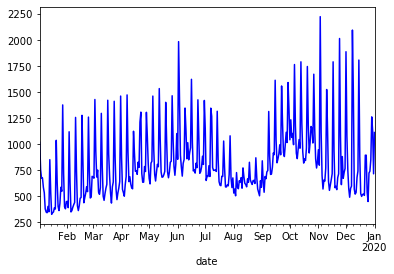

In [128]:
ax2=reviews_df_dates_19.groupby("date").id.count().plot(kind="line",c="blue")
ax2

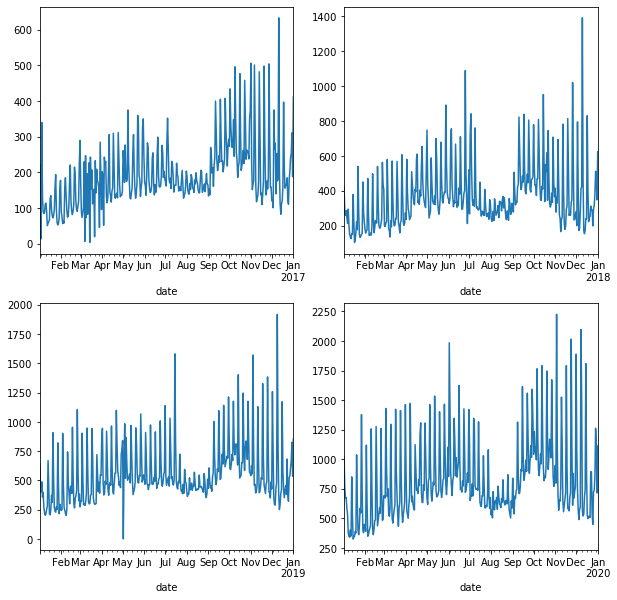

In [129]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))


reviews_df_dates_16.groupby("date").id.count().plot(ax=axs[0,0])
reviews_df_dates_17.groupby("date").id.count().plot(ax=axs[0,1])
reviews_df_dates_18.groupby("date").id.count().plot(ax=axs[1,0])
reviews_df_dates_19.groupby("date").id.count().plot(ax=axs[1,1])

fig.savefig("fig4trend.png")

Also, we can see some periods where the numbers of reviews decreases abruptly. From the plot bellow, divided in years, it is easy to see a strong seasonality. August and September seems to have the lowest number of ratings, which is probably translated in lower turist.